In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')
%matplotlib notebook

In [109]:
xmax = 20 #max x values in m
ymax = 20 #max y values in m
zmax = 20 #max z values in m
h = 1 #amount of space each point represents in m**3

In [110]:
space = np.zeros((xmax, ymax, zmax))

In [111]:
dv = 1
dr = (dv)**(1/3)

# Wind

In [112]:
def sun_e(space, eavg=1.08e7, estd=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *eavg*
            int average value of energy from sun in J/m**2/day;
            default = 1.08e7 (average over Chicago)
        *estd*
            int standard deviation of energy from sun from eavg;
            default = 1
    :Returns:
        *energies*
            numpy.array values of energy from sun in J/m**2/day using
            edist with mean eavg
    '''
    energies = np.zeros(space.shape)
    for i in range(np.array(space.shape)[0]):
        for j in range(np.array(space.shape)[1]):
            e = np.random.normal(loc=eavg, scale=estd)
            energies[i, j, -1] = e

    return energies

# Cloud

In [113]:
def cloud(space, loc=(10,10,10), size=(10,1,1), hcloud=1, hmed=.95, hair=.69):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            tuple location of center of cloud;
            default = (10,10,10)
        *size*
            tuple size of cloud;
            default = (10,1,1)
        *hcloud*
            int humidity of cloud;
            default = 1
        *hair*
            int humidity of air;
            default = 0
    :Returns:
        *humidities*
            numpy.array values of humidity
    '''
    assert all([i >= 0 for i in np.array(loc)-np.array(size)/2]) and \
    all([i >= 0 for i in np.array(space.shape)-np.array(loc)+np.array(size)/2]), \
    'Cloud must be within space.'

    humidities = space

    humidities[:][:][:] = hair

    n = np.array(size) % 2

    i = np.array(loc)[0]
    j = np.array(loc)[1]
    k = np.array(loc)[2]

    a0 = int(i-np.array(size)[0]/2)
    a1 = int(i+np.array(size)[0]/2) + n[0]
    b0 = int(j-np.array(size)[1]/2)
    b1 = int(j+np.array(size)[1]/2) + n[1]
    c0 = int(k-np.array(size)[2]/2)
    c1 = int(k+np.array(size)[2]/2) + n[2]

    humidities[a0-1:a1+1, b0-1:b1+1, c0-1:c1+1] = hmed
    humidities[a0:a1, b0:b1, c0:c1] = hcloud

    return humidities

# Tornado

In [114]:
def tornado(space, loc=10, lpress=10, rpress=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            int location of pressure difference;
            default = 10

    :Returns:
        *pressures*
            numpy.array values of pressure
    '''
    assert 0 < loc and loc < np.array(space.shape)[0], 'Pressure difference must be within space.'

    pressures = altitude_pressures(space)

    pressures[loc:, :, :] *= rpress

    pressures[:loc, :, :] *= lpress

    return pressures

# Algorithm: Wind

In [115]:
def energytopressure(energies, dV):
    ps = energies/dV
    return ps

In [116]:
def altitude_pressures(space):
    pressures = space
    for h in range(np.array(space.shape)[2]):
        p = 101325*np.e**(-0.000119806*h)
        pressures[:, :, h] = p
    return pressures

In [186]:
def calc_J_air(pressures, dV=dv, D=1.76e-5, T=329):
    R = 8.314598
    js = np.zeros([np.array(pressures.shape)[0], np.array(pressures.shape)[1], np.array(pressures.shape)[2], 9])
    for i in range(np.array(pressures.shape)[0]):
        for j in range(np.array(pressures.shape)[1]):
            for k in range(np.array(pressures.shape)[2]):
                p = pressures[i, j, k]

                n = p*dV/(R*T)
                phi = n/dV

                try:
                    assert i-1 != -1
                    pleft = pressures[i-1, j, k]
                    n = pleft*dV/(R*T)
                    phileft = n/dV
                    dphileft = phi - phileft
                except:
                    phileft = np.nan
                    dphileft = 0

                try:
                    pright = pressures[i+1, j, k]
                    n = pright*dv/(R*T)
                    phiright = n/dv
                    dphiright = phi - phiright
                except:
                    phiright = np.nan
                    dphiright = 0

                try:
                    assert j-1 != -1
                    pfront = pressures[i, j-1, k]
                    n = pfront*dV/(R*T)
                    phifront = n/dV
                    dphifront = phi - phifront
                except:
                    phifront = np.nan
                    dphifront = 0

                try:
                    pback = pressures[i, j+1, k]
                    n = pback*dV/(R*T)
                    phiback = n/dV
                    dphiback = phi - phiback
                except:
                    phiback = np.nan
                    dphiback = 0

                try:
                    assert k-1 != -1
                    pdown = pressures[i, j, k-1]
                    n = pdown*dV/(R*T)
                    phidown = n/dV
                    dphidown = phi - phidown
                except:
                    phidown = np.nan
                    dphidown = 0

                try:
                    pup = pressures[i, j, k+1]
                    n = pup*dV/(R*T)
                    phiup = n/dV
                    dphiup = phi - phiup
                except:
                    phiup = np.nan
                    dphiup = 0

                gradphix = (dphileft - dphiright)/2 #phiright-phileft
                gradphiy = (dphiback - dphifront)/2 #phifront-phiback
                gradphiz = (dphidown - dphiup)/2 #phiup-phidown

                gradphi = np.array([dphileft, dphiright, dphiback, dphifront, dphidown, dphiup,
                                    gradphix, gradphiy, gradphix])/(dV)**(1/3)
                J = gradphi
                js[i, j, k, :] = J
    return js

In [187]:
pressures = altitude_pressures(space)
energies = sun_e(space)
pressures += energytopressure(energies, dV)

R = 8.314598
js = np.zeros([np.array(pressures.shape)[0], np.array(pressures.shape)[1], np.array(pressures.shape)[2], 9])
for i in range(np.array(pressures.shape)[0]):
    for j in range(np.array(pressures.shape)[1]):
        for k in range(np.array(pressures.shape)[2]):
            p = pressures[i, j, k]

            n = p*dV/(R*T)
            phi = p/dV

            try:
                assert i-1 != -1
                pleft = pressures[i-1, j, k]
                n = pleft*dV/(R*T)
                phileft = pleft/dV
                dphileft = phi - phileft
            except:
                phileft = np.nan
                dphileft = 0

            try:
                pright = pressures[i+1, j, k]
                n = pright*dv/(R*T)
                phiright = pright/dv
                dphiright = phi - phiright
            except:
                phiright = np.nan
                dphiright = 0

            try:
                assert j-1 != -1
                pfront = pressures[i, j-1, k]
                n = pfront*dV/(R*T)
                phifront = pfront/dV
                dphifront = phi - phifront
            except:
                phifront = np.nan
                dphifront = 0

            try:
                pback = pressures[i, j+1, k]
                n = pback*dV/(R*T)
                phiback = pback/dV
                dphiback = phi - phiback
            except:
                phiback = np.nan
                dphiback = 0

            try:
                assert k-1 != -1
                pdown = pressures[i, j, k-1]
                n = pdown*dV/(R*T)
                phidown = pdown/dV
                dphidown = phi - phidown
            except:
                phidown = np.nan
                dphidown = 0

            try:
                pup = pressures[i, j, k+1]
                n = pup*dV/(R*T)
                phiup = pup/dV
                dphiup = phi - phiup
            except:
                phiup = np.nan
                dphiup = 0

            gradphix = (dphileft - dphiright)/2 #phiright-phileft
            gradphiy = (dphiback - dphifront)/2 #phifront-phiback
            gradphiz = (dphidown - dphiup)/2 #phiup-phidown

            gradphi = np.array([dphileft, dphiright, dphiback, dphifront, dphidown, dphiup,
                                gradphix, gradphiy, gradphix])/(dV)**(1/3)
            J = -D*gradphi
            js[i, j, k, :] = J

In [188]:
gradphi

array([ -1.50335537e+00,   0.00000000e+00,   0.00000000e+00,
        -8.30130925e-01,   1.07999870e+07,   0.00000000e+00,
        -7.51677685e-01,   4.15065463e-01,  -7.51677685e-01])

In [189]:
pressures[i-1:i+2, j-1:j+2, k-1:k+2]

array([[[   101106.72726494,  10901093.53804907],
        [   101106.72726494,  10901095.20860949]],

       [[   101106.72726494,  10901094.53538504],
        [   101106.72726494,  10901093.70525412]]])

In [190]:
gradphi

array([ -1.50335537e+00,   0.00000000e+00,   0.00000000e+00,
        -8.30130925e-01,   1.07999870e+07,   0.00000000e+00,
        -7.51677685e-01,   4.15065463e-01,  -7.51677685e-01])

In [191]:
def pressure_diffusion(pressures, dV=dv, T=329, dt=1):
    js = calc_J_air(pressures)
    R = 8.314598
    Rarray = R*np.ones(pressures.shape)
    ns = np.divide(pressures*dV, Rarray*T)

    for i in range(np.array(pressures.shape)[0]):
        for j in range(np.array(pressures.shape)[1]):
            for k in range(np.array(pressures.shape)[2]):
                a = -js[i, j, k, 0]/2*np.random.normal(loc=1, scale=.2)
                b = -js[i, j, k, 1]/2*np.random.normal(loc=1, scale=.2)
                c = -js[i, j, k, 2]/2*np.random.normal(loc=1, scale=.2)
                d = -js[i, j, k, 3]/2*np.random.normal(loc=1, scale=.2)
                e = -js[i, j, k, 4]/2*np.random.normal(loc=1, scale=.2)
                f = -js[i, j, k, 5]/2*np.random.normal(loc=1, scale=.2)

                if a > 0:
                    ns[i, j, k] += a
                    ns[i-1, j, k] -= a
                if b > 0:
                    ns[i, j, k] += b
                    ns[i+1, j, k] -= b

                if c > 0:
                    ns[i, j, k] += c
                    ns[i, j+1, k] -= c
                if d > 0:
                    ns[i, j, k] += d
                    ns[i, j-1, k] -= d

                if e > 0:
                    ns[i, j, k] += e
                    ns[i, j, k-1] -= e
                if f > 0:
                    ns[i, j, k] += f
                    ns[i, j, k+1] -= f

    pressures = ns*R*T/dV
    return pressures

In [192]:
def integrate_from_sun(space, dV=dv, tmax=20,
                       dt=1):
    pressures = np.zeros(space.shape)
    times = np.arange(0, tmax+1, dt)
    pt = np.zeros([len(times), np.array(space.shape)[0],
                   np.array(space.shape)[1], (np.array(space.shape)[2])])
    ps = altitude_pressures(space)
    for t in times:
        pt[t] = ps
        energies = sun_e(space)
        ps += energytopressure(energies, dV)
        print(ps[:, 10, :])
        ps = pressure_diffusion(ps, dt)
    return pt

In [193]:
pt = integrate_from_sun(space)

[[   101325.            101312.8613842     101300.7242226
     101288.58851501    101276.45426127    101264.3214612
     101252.19011462    101240.06022136    101227.93178125
     101215.80479411    101203.67925977    101191.55517806
     101179.4325488     101167.31137181    101155.19164693
     101143.07337397    101130.95655277    101118.84118315
     101106.72726494  10901094.26201039]
 [   101325.            101312.8613842     101300.7242226
     101288.58851501    101276.45426127    101264.3214612
     101252.19011462    101240.06022136    101227.93178125
     101215.80479411    101203.67925977    101191.55517806
     101179.4325488     101167.31137181    101155.19164693
     101143.07337397    101130.95655277    101118.84118315
     101106.72726494  10901095.14306047]
 [   101325.            101312.8613842     101300.7242226
     101288.58851501    101276.45426127    101264.3214612
     101252.19011462    101240.06022136    101227.93178125
     101215.80479411    101203.67925977

[[   101317.03480891    101312.91279701    101295.54672866
     101288.43475186    101280.47336124    101261.85555271
     101251.68228199    101238.83992112    101229.80251582
     101208.71123453    101210.89440193    101178.30633676
     101191.34307489    101163.78040599    101155.46511203
     101145.20956673    101123.34773086   3867380.36226732
    3516364.46014173  24634288.05671287]
 [   101311.35487397    101317.95576925    101297.24459583
     101289.49884881    101281.44799613    101264.32932662
     101238.17993764    101250.14812662    101227.37986272
     101215.94445314    101201.43709311    101186.30602915
     101183.50667794    101162.4020469     101164.52108102
     101141.06021297    101127.66798167   2680885.34434837
    7308195.06949315  22606924.64639696]
 [   101318.00911221    101303.18621742    101308.2444548
     101283.24810528    101274.59807832    101269.58354833
     101248.88887789    101239.77001415    101230.28225836
     101211.92510919    101204.684

[[   101320.3907373     101297.96361492    101278.11903438
     101296.53467323    101283.67971193    101245.12110092
     101303.14096201    101200.34484035    101273.73749392
     101148.64715554    101275.09942657    101129.905188      101229.16761583
     101171.09704597    101121.40051974    665704.40262484
    1247668.27941217  14311665.19995441  -1123999.70731912
   43395308.67365356]
 [   101263.88897135    101403.24012152    101243.90714785
     101288.4946122     101314.97089683    101266.44343766
     101136.96243544    101355.04154158    101155.26104845
     101292.44022142    101151.46562274    101185.72024585
     101219.8004511     101075.55253075    101291.60076266
     780883.62243737   2164045.16047055   9993323.55614034
   -2978949.40297215  44809744.71265443]
 [   101365.22148006    101186.08568603    101401.4986991
     101239.24126918    101249.04604442    101329.80611       101240.03342347
     101182.72241348    101309.25116259    101147.27682611
     101213.832

[[  1.00454821e+05   1.02571715e+05   1.00902412e+05   1.01012421e+05
    1.01706088e+05   1.01715040e+05   9.88068500e+04   1.04966732e+05
    9.70881053e+04   1.05548165e+05   9.79964401e+04   1.03164621e+05
    1.68066178e+05   4.03699093e+05   1.94985938e+06  -1.55611546e+07
    5.20639727e+07   1.96909231e+07  -1.99793445e+08   2.14363118e+08]
 [  1.03125824e+05   9.71296373e+04   1.04765298e+05   1.00968234e+05
    9.97224500e+04   1.01712236e+05   1.05629171e+05   9.36788603e+04
    1.08359608e+05   9.47898637e+04   1.05466115e+05   1.01756537e+05
    1.54684018e+05   6.47773364e+05   2.38830711e+05  -9.14313335e+06
    1.82659786e+08  -8.67489648e+08   1.57592586e+09  -1.08115423e+09]
 [  9.91140285e+04   1.08910628e+05   9.37297323e+04   1.04186491e+05
    1.03624588e+05   9.72684751e+04   1.01829026e+05   1.05704018e+05
    9.33414373e+04   1.06547244e+05   9.91636016e+04   9.77883097e+04
    1.79501880e+05   6.71153291e+05  -3.93085435e+06   5.63754163e+07
   -4.39329924e+08

[[  8.94896000e+04   1.31244965e+05   8.18757440e+04   1.03035123e+05
    1.08313330e+05   1.03330499e+05   7.02221084e+04   1.70576194e+05
    3.41895308e+04   1.70710960e+05   8.19528830e+04   2.03276087e+05
    7.65907293e+05  -7.53402073e+06   3.90391759e+07   2.20223690e+07
   -7.14012242e+08   4.42592453e+09  -9.18450298e+09   5.00353820e+09]
 [  1.43598373e+05  -5.53278060e+03   1.57907938e+05   7.77115993e+04
    7.59505829e+04   1.18041061e+05   1.51060778e+05  -3.49459618e+04
    2.32747661e+05  -2.74963416e+04   1.81190639e+05   3.52964550e+05
   -1.44977578e+06   1.92886553e+06   1.01062407e+08  -1.25015009e+09
    6.30291119e+09  -2.01616480e+10   3.40863097e+10  -2.09218711e+10]
 [  3.67916806e+04   2.61138257e+05  -2.45621863e+04   1.48811737e+05
    1.39855023e+05   3.97107810e+04   1.12362930e+05   1.94162649e+05
   -5.64163866e+04   2.28431997e+05   6.68085566e+04   1.11491764e+05
   -9.14699242e+05   3.95010094e+07  -5.04716225e+08   3.33825542e+09
   -1.43307575e+10

[[  1.46637427e+06  -2.80647195e+06   2.81682805e+06  -6.16515294e+05
   -3.70456802e+05   2.62387535e+05   1.83054285e+06  -3.14547068e+06
    3.57107758e+06  -3.72928593e+06   3.87045794e+05   2.83961731e+07
   -6.18123512e+07  -8.36967777e+08   1.06677138e+10  -6.68662543e+10
    2.78359140e+11  -5.56335288e+11   9.56772746e+11  -5.08680002e+11]
 [ -4.17211823e+06   9.94892447e+06  -7.94461220e+06   3.31428804e+06
    1.71008287e+06  -1.78074950e+06  -2.24123487e+06   9.29535504e+06
   -1.17223468e+07   1.09590604e+07   1.25511342e+06  -2.71305898e+06
   -5.14721385e+08   8.32859829e+09  -4.41542045e+10   2.92972472e+11
   -9.62795235e+11   2.54505186e+12  -3.38944471e+12   1.60318209e+12]
 [  6.26063603e+06  -1.36393874e+07   1.30211204e+07  -6.45654460e+06
   -2.43227405e+06   7.13525512e+06  -1.31328225e+06  -7.49981515e+06
    1.25122613e+07  -1.18419156e+07   1.08475100e+07  -2.23568246e+08
    1.92985672e+09  -1.49321719e+10   1.27261741e+11  -5.61360175e+11
    1.74561246e+12

[[ -1.64073041e+08   2.60212404e+08  -2.65677242e+08   1.27477765e+08
    7.58819177e+06  -2.46095303e+07  -1.24324340e+08   3.89058052e+08
   -3.87721647e+08   3.17044598e+08  -9.80736605e+07   6.39988856e+09
   -8.31210334e+10   5.50585466e+11  -3.53467041e+12   1.55847266e+13
   -3.97180164e+13   7.15179828e+13  -7.00944854e+13   4.98509803e+13]
 [  4.06647709e+08  -6.74948679e+08   7.39014603e+08  -3.61964289e+08
   -6.69698647e+07   1.91293884e+08   9.48740352e+07  -6.89471992e+08
    9.87102469e+08  -9.21135643e+08   3.75243400e+09  -4.67510208e+10
    4.48356141e+11  -2.27530198e+12   1.40253525e+13  -4.38828911e+13
    1.33255699e+14  -2.54836593e+14   2.95836028e+14  -1.51032855e+14]
 [ -6.29302553e+08   1.42294061e+09  -1.37366490e+09   6.49080591e+08
    1.10426216e+08  -4.12920386e+08   2.31465651e+08   4.35053102e+08
   -9.99243278e+08   1.57502962e+09  -9.18445440e+09   1.38270455e+11
   -6.01942406e+11   3.92903121e+12  -1.80490813e+13   5.98809110e+13
   -2.20991834e+14

[[ -1.90489231e+09   5.72268135e+09  -5.86643270e+09   3.68965326e+09
   -1.58053165e+08  -8.15543944e+08  -1.71528441e+09   6.22266260e+09
   -5.56320607e+09   6.56784803e+09  -6.96967711e+10   6.59031586e+11
   -4.37998056e+12   2.75885497e+13  -1.15303736e+14   4.58971820e+14
   -1.06378519e+15   2.13400692e+15  -1.82935845e+15   7.57520036e+14]
 [  6.56092147e+09  -1.79152520e+10   2.06920478e+10  -1.25259397e+10
    1.37552733e+08   4.18146304e+09   8.98793011e+08  -1.27697295e+10
    1.64005376e+10  -4.40146998e+10   4.77280370e+11  -2.89391069e+12
    2.29205833e+13  -8.94260279e+13   3.74870508e+14  -1.30680717e+15
    3.18672563e+15  -5.69911756e+15   4.67065479e+15  -2.30318132e+15]
 [ -1.31163394e+10   2.99258374e+10  -3.43596329e+10   1.77490657e+10
   -3.19561434e+08  -7.95456881e+09   5.42209907e+09   7.29007380e+09
   -1.98483403e+10   9.64868362e+10  -4.93497811e+11   3.49203324e+12
   -2.83644003e+13   1.47887999e+14  -7.20422692e+14   1.76322778e+15
   -5.41956739e+15

[[  3.03226146e+11  -6.43720065e+11   6.63228591e+11  -3.63292592e+11
    9.02071447e+10   6.74613044e+10   5.50303342e+10  -3.43193801e+11
    1.12450564e+12  -6.20561832e+12   4.08241722e+13  -3.02944305e+14
    1.28636948e+15  -6.40247421e+15   2.20109205e+16  -5.70663017e+16
    1.25052979e+17  -1.87724522e+17   1.35513780e+17  -7.64060459e+16]
 [ -9.49004612e+11   2.14535619e+12  -2.10513708e+12   1.12063462e+12
   -2.40989573e+11  -2.99539723e+11   5.21993628e+10   7.26910353e+11
   -3.45842386e+12   2.02913124e+13  -1.17070356e+14   8.64900936e+14
   -3.74063778e+15   1.97782575e+16  -6.58328301e+16   1.81686583e+17
   -3.67651611e+17   5.94896297e+17  -4.77155168e+17   2.17301436e+17]
 [  1.26289269e+12  -2.71435388e+12   3.00738104e+12  -1.88966859e+12
    3.37580442e+11   7.83235935e+11  -6.33899488e+11  -6.27747402e+11
    3.95235017e+12  -3.18045303e+13   2.26680093e+14  -1.32814259e+15
    7.77772112e+15  -2.33220953e+16   8.52902708e+16  -2.27627960e+17
    4.41105714e+17

In [194]:
pt[10, :, 10, :]

array([[  1.64844234e+05,  -4.52587589e+04,   2.00867676e+05,
          7.51800135e+04,   7.41923709e+04,   1.04127794e+05,
          2.40361518e+05,  -1.46205779e+05,   3.75552238e+05,
         -1.99001227e+05,   3.50592766e+05,   4.75249491e+05,
         -4.07301747e+06,   3.99981923e+07,  -1.89245881e+07,
         -7.97245902e+08,   6.83704794e+09,  -2.38083101e+10,
          3.84468906e+10,  -2.35738476e+10],
       [ -1.04017191e+05,   5.76924067e+05,  -2.32255496e+05,
          2.15348560e+05,   1.86131163e+05,   3.15523989e+04,
         -9.29799641e+04,   6.70881796e+05,  -5.52753274e+05,
          6.81068559e+05,  -5.47202156e+04,  -1.19562082e+06,
          6.56483778e+06,   7.57398401e+07,  -8.71658259e+08,
          7.41707217e+09,  -3.60222608e+10,   1.14902128e+11,
         -1.63835528e+11,   8.83158477e+10],
       [  3.80690005e+05,  -5.12241382e+05,   7.85888716e+05,
         -1.72027589e+05,  -4.04852089e+04,   4.18865305e+05,
          5.12263655e+04,  -3.74866455e+05

# Algorithm: Cloud

In [201]:
def calc_J_water(humidities, dV=dv, D=1.76e-5, T=329):
    js = np.zeros([np.array(humidities.shape)[0], np.array(humidities.shape)[1], np.array(humidities.shape)[2], 3])
    for i in range(np.array(humidities.shape)[0]):
        for j in range(np.array(humidities.shape)[1]):
            for k in range(np.array(humidities.shape)[2]):
                h = humidities[i, j, k]

                try:
                    assert i-1 != -1
                    hleft = humidities[i-1, j, k]
                    phileft = hleft
                    dphileft = phi - phileft
                except:
                    phileft = np.nan
                    dphileft = 0

                try:
                    hright = humidities[i+1, j, k]
                    phiright = hright
                    dphiright = phi - phiright
                except:
                    phiright = np.nan
                    dphiright = 0

                try:
                    assert j-1 != -1
                    hfront = humidities[i, j-1, k]
                    phifront = hfront
                    dphifront = phi - phifront
                except:
                    phifront = np.nan
                    dphifront = 0

                try:
                    hback = humidities[i, j+1, k]
                    phiback = hback
                    dphiback = phi - phiback
                except:
                    phiback = np.nan
                    dphiback = 0

                try:
                    assert k-1 != -1
                    hdown = humidities[i, j, k-1]
                    phidown = hdown
                    dphidown = phi - phidown
                except:
                    phidown = np.nan
                    dphidown = 0

                try:
                    hup = humidities[i, j, k+1]
                    phiup = hup
                    dphiup = phi - phiup
                except:
                    phiup = np.nan
                    dphiup = 0

                gradphix = (dphileft - dphiright)/2 #phiright-phileft
                gradphiy = (dphiback - dphifront)/2 #phifront-phiback
                gradphiz = (dphidown - dphiup)/2 #phiup-phidown

                gradphi = np.array([gradphix, gradphiy, gradphix])/(dV)**(1/3)
                J = -D*gradphi
                js[i, j, k, :] = J
    return js

In [202]:
def water_diffusion(humidities, dV=dv, dt=1):
    js = calc_J_water(humidities)
    ns = humidities*dV

    for i in range(np.array(humidities.shape)[0]):
        for j in range(np.array(humidities.shape)[1]):
            for k in range(np.array(humidities.shape)[2]):
                if js[i, j, k, 0] < 0:
                    try:
                        ns[i, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i+1, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)
                    except:
                        ns[i-1, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)
                else:
                    try:
                        ns[i, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i-1, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)
                    except:
                        ns[i+1, j, k] += js[i, j, k, 0]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 0]*dt*(dV)**(2/3)

                if js[i, j, k, 1] < 0:
                    try:
                        ns[i, j, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j+1, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)
                    except:
                        ns[i, j-1, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)
                else:
                    try:
                        ns[i, j, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j-1, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)
                    except:
                        ns[i, j+1, k] += js[i, j, k, 1]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 1]*dt*(dV)**(2/3)

                if js[i, j, k, 2] < 0:
                    try:
                        ns[i, j, k] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k+1] -= js[i, j, k, 2]*dt*(dV)**(2/3)
                    except:
                        ns[i, j, k-1] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 2]*dt*(dV)**(2/3)
                else:
                    try:
                        ns[i, j, k] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k-1] -= js[i, j, k, 2]*dt*(dV)**(2/3)
                    except:
                        ns[i, j, k+1] += js[i, j, k, 2]*dt*(dV)**(2/3)
                        ns[i, j, k] -= js[i, j, k, 2]*dt*(dV)**(2/3)

    humidities = ns/dV
    return humidities

In [203]:
def integrate_from_cloud(space, loc=(10, 10, 10), size=(5, 1, 1), dV=dv, tmax=20,
                       dt=1):
    humidities = np.zeros(space.shape)
    times = np.arange(0, tmax, dt)
    ht = np.zeros([len(times), np.array(space.shape)[0],
                   np.array(space.shape)[1], (np.array(space.shape)[2])])
    hs = cloud(space, loc=loc, size=size)
    for t in times:
        ht[t] = hs
        hs = water_diffusion(hs, dt)
    return ht

In [204]:
integrate_from_cloud(space)

array([[[[ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         ..., 
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69]],

        [[ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         ..., 
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69]],

        [[ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         ..., 
         [ 0.69,  0.69,  0.69, ...,  0.69,  0.69,  0.69],
         [ 0.69,  0.69,

In [205]:
pt[t, x, y, z]

NameError: name 'y' is not defined

In [ ]:
ht[t, x, y, z]

# Algorithm: Tornado

In [ ]:
xs, ys = np.meshgrid(np.arange(np.array(pt.shape)[0])*dr, np.arange(np.array(pt.shape)[2])*dr)
zs = pt[0,:,0,:]

In [196]:
pt[1,:,10,:]

array([[  101319.06821251,   101310.98190623,   101302.88954787,
          101289.76866134,   101272.36410383,   101265.74744783,
          101254.31994833,   101239.17494147,   101226.47596762,
          101217.94913112,   101201.53550096,   101195.46320898,
          101175.02556539,   101168.12925462,   101155.3109801 ,
          101143.40735326,   101132.37760517,   101117.47008553,
         6999537.99335059,  4002670.3129461 ],
       [  101320.18610101,   101310.60669218,   101301.93705039,
          101287.59789854,   101274.63047064,   101264.93991148,
          101258.98941849,   101235.02373462,   101226.40236058,
          101217.35952337,   101203.60446831,   101193.83322673,
          101178.46135663,   101168.71263089,   101151.4674983 ,
          101143.72971427,   101132.7047342 ,   101118.75993709,
         6355727.3221815 ,  4646477.53994687],
       [  101317.97888591,   101314.09836587,   101299.57087571,
          101289.95990355,   101277.46450518,   101262.781641

In [197]:
def plot_surf(y_t, Dt=dr, Dx=dr, step=1, filename=None, offset=-1,
             elevation=40, azimuth=20, cmap=plt.cm.coolwarm):
    """Plot y_t as a 3D plot with contour plot underneath.
    
    Arguments
    ---------
    y_t : 2D array
          displacement y(t, x)
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    offset : float, optional (default: 20)
          position the 2D contour plot by offset along the Z direction
          under the minimum Z value
    zlabel : string, optional
          label for the Z axis and color scale bar
    elevation : float, optional
          choose elevation for initial viewpoint
    azimuth : float, optional
          chooze azimuth angle for initial viewpoint
    """
     
    t = np.arange(y_t.shape[0])
    x = np.arange(y_t.shape[1])
    T, X = np.meshgrid(t, x)
    Y = y_t.T[X, T]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X*Dx, T*Dt*step, Y, cmap=cmap, rstride=1, cstride=1, alpha=1)
    cset = ax.contourf(X*Dx, T*Dt*step, Y, 20, zdir='z', offset=offset+Y.min(), cmap=cmap)

    ax.set_xlabel(r'x position $x$ (m)')
    ax.set_ylabel(r'z position $z$ (m)')
    ax.set_zlabel(r'Pressure $P$ (Pa)')
    ax.set_zlim(offset + Y.min(), Y.max())
    
    ax.view_init(elev=elevation, azim=azimuth)

    cb = fig.colorbar(surf, shrink=0.5, aspect=5)
    cb.set_label('pressure')
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax

def plot_y(y_t, Dx=dr, Dt=dr, step=1):
    X, Y = np.meshgrid(range(y_t.shape[0]), range(y_t.shape[1]))
    Z = y_t.T[Y, X]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(Y*Dx, X*Dt*step, Z)
    ax.set_xlabel(r'x position $x$ (m)')
    ax.set_ylabel(r'z position $z$ (m)')
    ax.set_zlabel(r'Pressure $P$ (Pa)')
    fig.tight_layout()
    return ax

In [200]:
pt = np.transpose(pt)

<IPython.core.display.Javascript object>


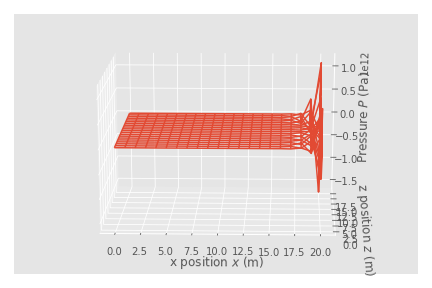

In [201]:
ax0 = plot_y(pt[0,:,10,:])

<IPython.core.display.Javascript object>


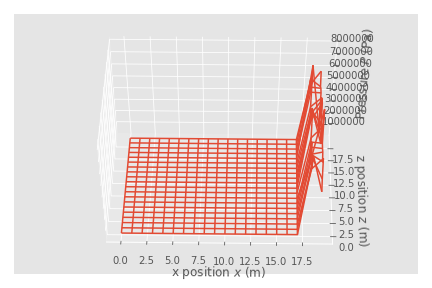

In [199]:
ax1 = plot_y(pt[1,:,10,:])

<IPython.core.display.Javascript object>


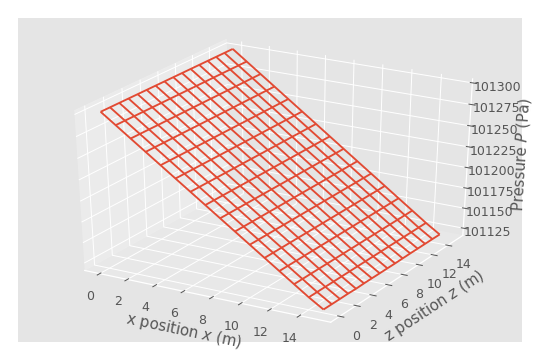

In [207]:
ax10 = plot_y(pt[19,:,10,:])